In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/datasetV22.zip"
extract_path = "/content/fashion_dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ فایل‌ها با موفقیت اکسترکت شدند.")


✅ فایل‌ها با موفقیت اکسترکت شدند.


In [ ]:
# بررسی فایل‌ها
print(os.listdir(extract_path))
inner_path = os.path.join(extract_path, 'datasetV22')
print(os.listdir(inner_path))


['datasetV22']
['styles.csv', 'images']


این سلول وظیفه آماده‌سازی دیتافریم اصلی پروژه را بر عهده دارد.
در این مرحله، ابتدا فایل داده‌ها (styles.csv) خوانده می‌شود و ردیف‌هایی که فاقد id هستند یا تصویرشان در پوشه‌ی تصاویر وجود ندارد حذف می‌شوند.
سپس فقط ردیف‌هایی نگه داشته می‌شود که همه‌ی برچسب‌های مهم (۷ ستون اصلی) را دارند.
در نهایت، تعداد نمونه‌های معتبر چاپ و پنج ردیف اول دیتافریم نمایش داده می‌شود.
این کار باعث می‌شود فقط داده‌های کاملاً سالم برای آموزش و ارزیابی مدل استفاده شوند.

In [ ]:
import pandas as pd
import os

data_path = "/content/fashion_dataset/datasetV22"
csv_path = os.path.join(data_path, "styles.csv")
images_path = os.path.join(data_path, "images")

df = pd.read_csv(csv_path, on_bad_lines='skip')

# حذف ردیف‌های بدون id
df = df.dropna(subset=['id'])

df['id'] = df['id'].astype(int).astype(str)
df['image_path'] = df['id'].apply(lambda x: os.path.join(images_path, x + ".jpg"))

# حذف ردیف‌هایی که عکسشون وجود نداره
df = df[df['image_path'].apply(os.path.exists)]

# انتخاب ستون‌های موردنیاز برای برچسب‌گذاری
label_columns = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']
df = df.dropna(subset=label_columns)

print("✅ تعداد نمونه‌های معتبر:", len(df))
df.head()


✅ تعداد نمونه‌های معتبر: 44074


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/content/fashion_dataset/datasetV22/images/159...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/content/fashion_dataset/datasetV22/images/393...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/content/fashion_dataset/datasetV22/images/592...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/content/fashion_dataset/datasetV22/images/213...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/content/fashion_dataset/datasetV22/images/537...


در این سلول، برای هر ستون برچسب (label)، یک LabelEncoder ساخته می‌شود تا مقادیر متنی برچسب‌ها به عدد تبدیل شوند و مدل بتواند آن‌ها را پردازش کند.
این لیبل‌های عددی در ستون‌های جدید با پسوند _enc ذخیره می‌شوند.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col])
    label_encoders[col] = le


در این سلول دیتافریم نهایی ساخته می‌شود که فقط شامل مسیر عکس و لیبل‌های عددی (برای هر ویژگی) است و برای آموزش مدل آماده می‌شود.

In [ ]:
df_final = df[['image_path'] + [col + '_enc' for col in label_columns]].copy()


در این سلول داده‌ها به دو بخش آموزش (۸۰٪) و اعتبارسنجی (۲۰٪) تقسیم می‌شوند تا مدل همزمان یاد بگیرد و ارزیابی شود.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_final, test_size=0.2, random_state=42)


در این سلول یک DataGenerator سفارشی ساخته می‌شود که تصاویر را از مسیرشان می‌خواند، آن‌ها را به سایز مشخص تبدیل و نرمالیزه می‌کند و همزمان لیبل عددی تمام ستون‌ها را آماده می‌کند.
این جنریتور داده‌ها را به صورت batch به مدل تحویل می‌دهد و امکان شفل کردن داده‌ها بعد از هر epoch را نیز دارد.

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

class MultiOutputDataGenerator(Sequence):
    def __init__(self, df, batch_size, img_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        X = []
        ys = {col + '_enc': [] for col in label_columns}
        for _, row in batch_df.iterrows():
            try:
                img = load_img(row['image_path'], target_size=self.img_size)
                img = img_to_array(img) / 255.0
                X.append(img)
                for col in label_columns:
                    ys[col + '_enc'].append(row[col + '_enc'])
            except:
                continue
        X = np.array(X)
        for col in label_columns:
            ys[col + '_enc'] = np.array(ys[col + '_enc'])
        return X, ys

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


در این سلول، سایز تصویر و اندازه batch تعریف می‌شود و دو جنریتور برای داده‌های آموزش و اعتبارسنجی ساخته می‌شود تا داده‌ها آماده ورود به مدل باشند.

In [ ]:
img_size = (80, 60)
batch_size = 64

train_gen = MultiOutputDataGenerator(train_df, batch_size, img_size)
val_gen = MultiOutputDataGenerator(val_df, batch_size, img_size)


با این سلول، یک batch نمونه از جنریتور آموزش استخراج و ابعاد تصاویر و لیبل‌ها چاپ می‌شود تا صحت آماده‌سازی داده‌ها بررسی شود.

In [ ]:
X, ys = train_gen[0]
print(X.shape)
for k in ys:
    print(k, ys[k].shape)


(64, 80, 60, 3)
gender_enc (64,)
masterCategory_enc (64,)
subCategory_enc (64,)
articleType_enc (64,)
baseColour_enc (64,)
season_enc (64,)
usage_enc (64,)


در این سلول معماری مدل تعریف می‌شود:
یک شبکه عصبی کانولوشنی با چند لایه کانولوشن، Flatten و Dense ساخته می‌شود.
در انتهای مدل، به ازای هر ستون برچسب (label)، یک لایه خروجی جداگانه با softmax وجود دارد که مدل را به یک مدل multi-task تبدیل می‌کند.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(80, 60, 3))
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = []
for col in label_columns:
    n_classes = df[col].nunique()
    outputs.append(Dense(n_classes, activation='softmax', name=col + '_enc')(x))

model = Model(inputs=input_layer, outputs=outputs)


In [ ]:
losses = {col + '_enc': 'sparse_categorical_crossentropy' for col in label_columns}
metrics = {col + '_enc': 'accuracy' for col in label_columns}

model.compile(optimizer='adam', loss=losses, metrics=metrics)


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10   # (یا بیشتر اگر زمان و GPU داشتی؛ مثلا 15 تا 20)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 261s 463ms/step - articleType_enc_accuracy: 0.3654 - articleType_enc_loss: 2.7872 - baseColour_enc_accuracy: 0.2959 - baseColour_enc_loss: 2.6469 - gender_enc_accuracy: 0.6920 - gender_enc_loss: 0.7915 - loss: 10.0580 - masterCategory_enc_accuracy: 0.8094 - masterCategory_enc_loss: 0.5443 - season_enc_accuracy: 0.5143 - season_enc_loss: 1.0782 - subCategory_enc_accuracy: 0.6271 - subCategory_enc_loss: 1.5127 - usage_enc_accuracy: 0.7929 - usage_enc_loss: 0.6971 - val_articleType_enc_accuracy: 0.6949 - val_articleType_enc_loss: 1.1369 - val_baseColour_enc_accuracy: 0.5059 - val_baseColour_enc_loss: 1.7503 - val_gender_enc_accuracy: 0.8274 - val_gender_enc_loss: 0.4664 - val_loss: 5.1476 - val_masterCategory_enc_accuracy: 0.9629 - val_masterCategory_enc_loss: 0.1283 - val_season_enc_accuracy: 0.6552 - val_season_enc_loss: 0.7984 - val_subCategory_enc_accuracy: 0.8755 - val_subCategory_enc_loss: 0.4669 - val_usage_enc_accuracy: 0.8654 - val_usage_en

این تابع یک تصویر را می‌گیرد، آن را برای مدل آماده می‌کند و با مدل آموزش‌دیده پیش‌بینی انجام می‌دهد.
برای هر ستون برچسب، مقدار پیش‌بینی‌شده به مقدار متنی (واقعی) تبدیل و در خروجی به صورت دیکشنری بازگردانده می‌شود.
این تابع برای تست مدل روی عکس جدید یا داده validation کاربرد دارد.

In [ ]:
def predict_multioutput(image_path, model, label_encoders, img_size=(80,60)):
    # بارگذاری و آماده‌سازی تصویر
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # پیش‌بینی مدل (هر ستون یک خروجی جداگانه)
    preds = model.predict(img_array)
    result = {}
    for i, col in enumerate(label_columns):
        pred_label_enc = np.argmax(preds[i][0])
        label = label_encoders[col].inverse_transform([pred_label_enc])[0]
        result[col] = label
    return result


In [ ]:
sample_path = df_final.iloc[0]['image_path']
predicted_labels = predict_multioutput(sample_path, model, label_encoders)

print("تگ‌های پیش‌بینی‌شده:")
for k, v in predicted_labels.items():
    print(f"{k}: {v}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
تگ‌های پیش‌بینی‌شده:
gender: Men
masterCategory: Apparel
subCategory: Topwear
articleType: Shirts
baseColour: Blue
season: Fall
usage: Casual


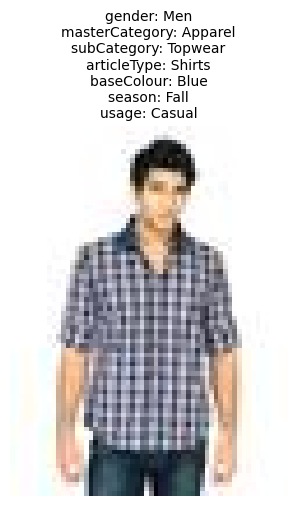

In [ ]:
import matplotlib.pyplot as plt

def show_prediction(image_path, predicted_labels):
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    title = '\n'.join([f"{k}: {v}" for k, v in predicted_labels.items()])
    plt.title(title, fontsize=10)
    plt.show()

# فراخوانی:
show_prediction(sample_path, predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


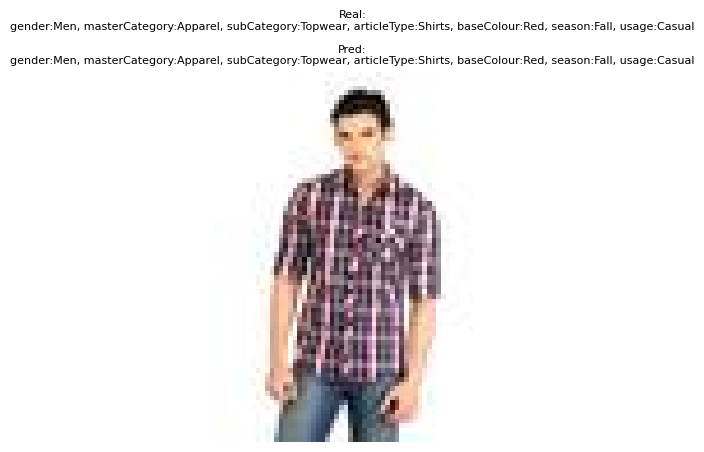

Real: {'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Shirts', 'baseColour': 'Red', 'season': 'Fall', 'usage': 'Casual'}
Pred: {'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Shirts', 'baseColour': 'Red', 'season': 'Fall', 'usage': 'Casual'}


In [ ]:
import random
import matplotlib.pyplot as plt

def predict_multioutput(image_path, model, label_encoders, img_size=(80,60)):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)
    result = {}
    for i, col in enumerate(label_columns):
        pred_label_enc = np.argmax(preds[i][0])
        label = label_encoders[col].inverse_transform([pred_label_enc])[0]
        result[col] = label
    return result

def show_real_vs_pred(df_final, model, label_encoders, img_size=(80,60)):
    # انتخاب رندوم یک عکس
    i = random.randint(0, len(df_final) - 1)
    row = df_final.iloc[i]
    image_path = row['image_path']

    # برچسب‌های واقعی
    real_labels = {col: label_encoders[col].inverse_transform([row[col + '_enc']])[0] for col in label_columns}
    # برچسب‌های پیش‌بینی‌شده
    pred_labels = predict_multioutput(image_path, model, label_encoders, img_size)

    # نمایش عکس و برچسب‌ها
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    title = "Real:\n" + ', '.join([f"{k}:{v}" for k,v in real_labels.items()]) + \
            "\n\nPred:\n" + ', '.join([f"{k}:{v}" for k,v in pred_labels.items()])
    plt.title(title, fontsize=8)
    plt.show()

    # چاپ همزمان در ترمینال
    print("Real:", real_labels)
    print("Pred:", pred_labels)

# استفاده:
show_real_vs_pred(df_final, model, label_encoders)


In [ ]:
model.save('/content/drive/MyDrive/my_fashion_multitask_model.h5')


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving photo_2025-07-15_01-01-14.jpg to photo_2025-07-15_01-01-14.jpg


In [ ]:
img_path = list(uploaded.keys())[0]


In [ ]:
predicted_labels = predict_multioutput(img_path, model, label_encoders)

print("پیش‌بینی مدل روی عکس بیرونی:")
for k, v in predicted_labels.items():
    print(f"{k}: {v}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
پیش‌بینی مدل روی عکس بیرونی:
gender: Men
masterCategory: Apparel
subCategory: Bottomwear
articleType: Jeans
baseColour: Blue
season: Summer
usage: Casual


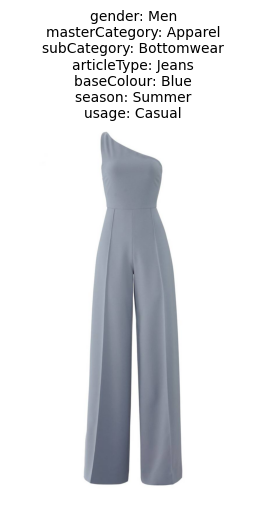

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

img = load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.title('\n'.join([f"{k}: {v}" for k, v in predicted_labels.items()]), fontsize=10)
plt.show()


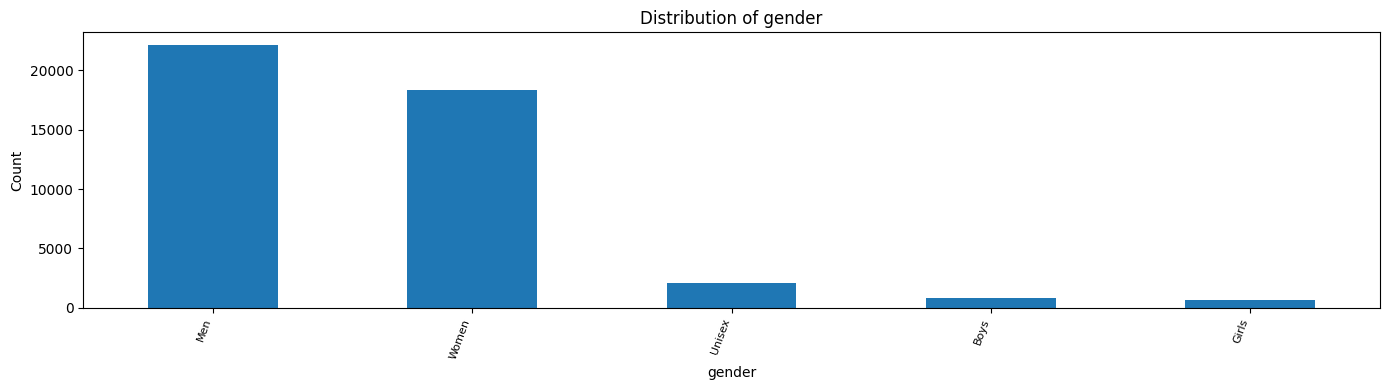

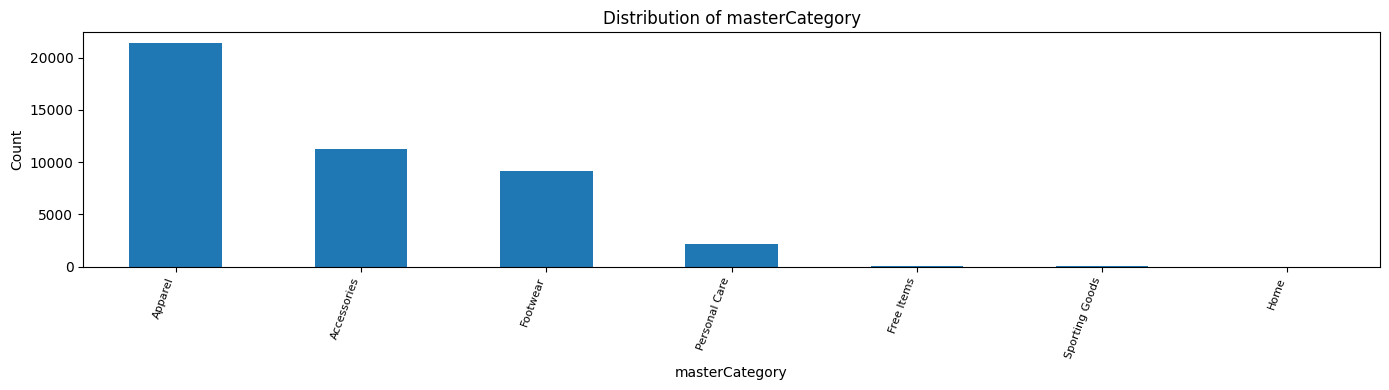

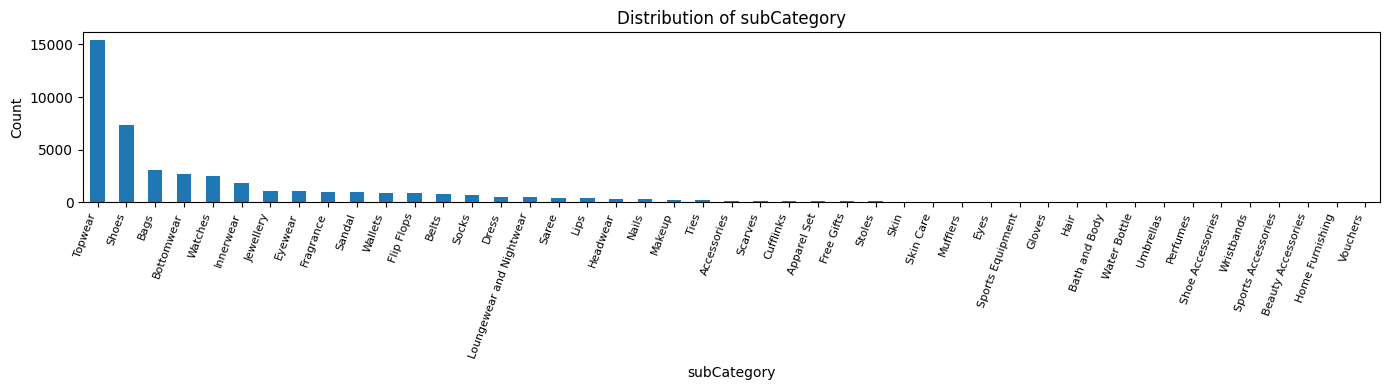

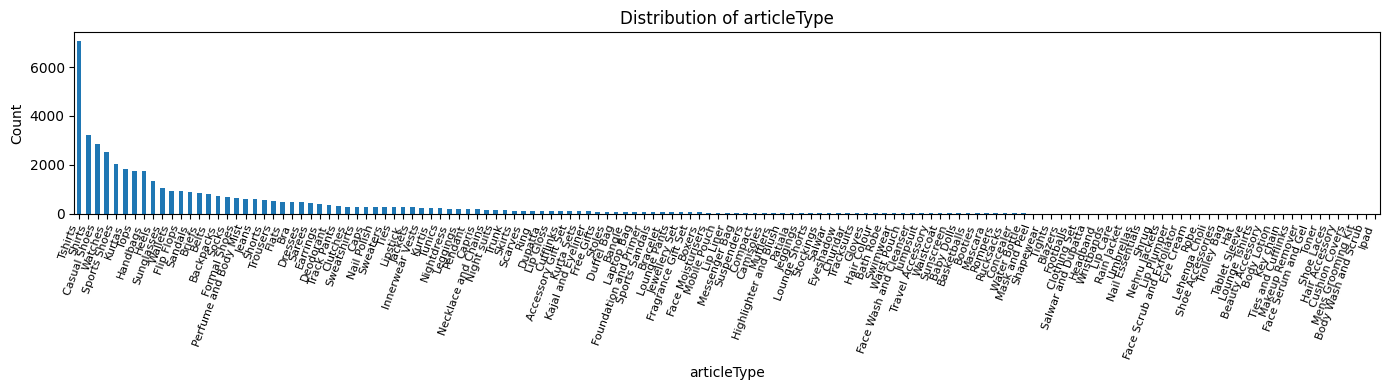

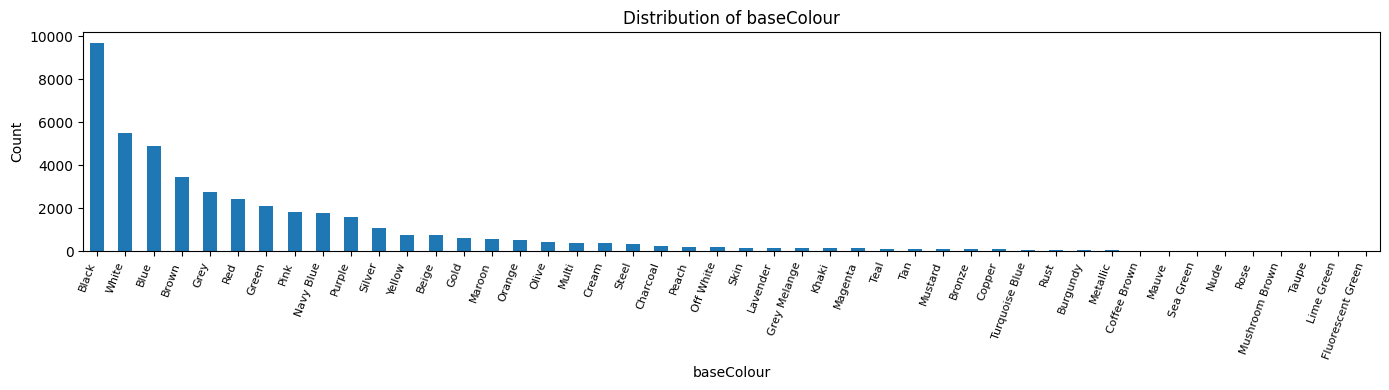

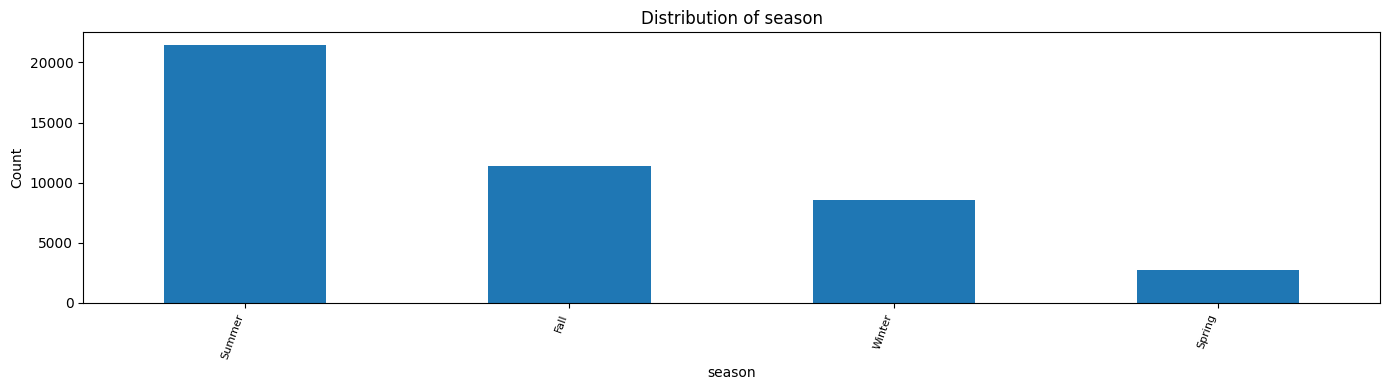

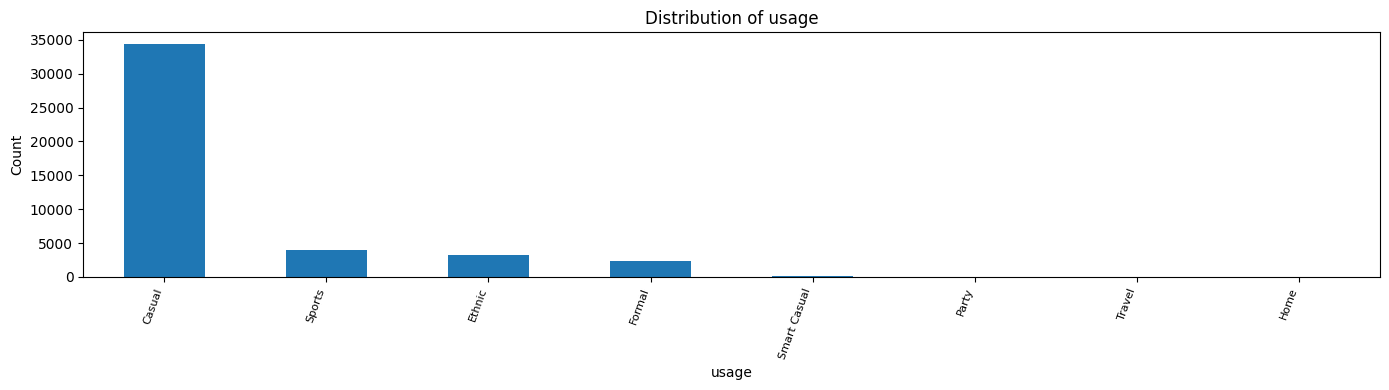

In [ ]:
for col in label_columns:
    plt.figure(figsize=(14,4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=70, ha='right', fontsize=8)
    plt.tight_layout()
    plt.show()


در این سلول، روند تغییر دقت (accuracy) مدل برای برچسب جنسیت (gender) در طول epochهای آموزش و اعتبارسنجی رسم می‌شود.
این نمودار نشان می‌دهد که مدل چقدر در طول زمان روی داده‌های آموزش و validation بهتر شده و آیا به overfitting یا بهبود واقعی رسیده است.
برای سایر ستون‌ها نیز می‌توان همین روند را رسم کرد.

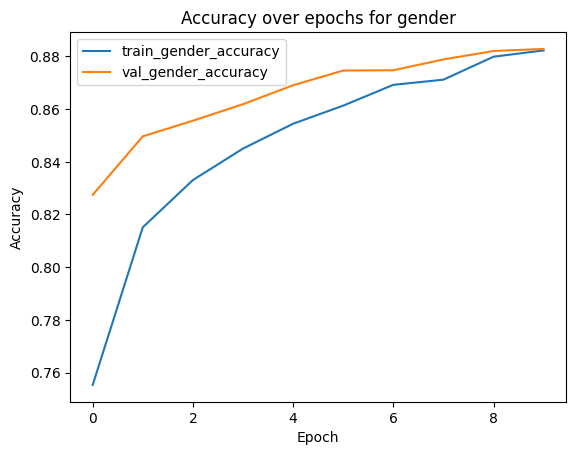

In [ ]:
# برای accuracy و loss کل train و val (در Multi-task باید دقت یک ستون خاص رو بگیری)
plt.plot(history.history['gender_enc_accuracy'], label='train_gender_accuracy')
plt.plot(history.history['val_gender_enc_accuracy'], label='val_gender_accuracy')
plt.legend()
plt.title('Accuracy over epochs for gender')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# به همین روش برای loss یا ستون‌های دیگه هم می‌تونی رسم کنی.
